In [ ]:
from google.colab import files
uploaded = files.upload()  # upload train.xlsx and test.csv

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
# 📚 Step 2: Import Libraries
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# ========================================
# 🧾 Step 3: Load Datasets
# ========================================
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Clean column names
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print("✅ Shape of Train:", train_df.shape)
print("✅ Shape of Test:", test_df.shape)
print("✅ Columns:", train_df.columns.tolist())


✅ Shape of Train: (15533, 18)
✅ Shape of Test: (5225, 17)
✅ Columns: ['id', 'Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'WeightCategory']



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  float64
 12  SCC       

/tmp/ipython-input-797349288.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='WeightCategory', data=train_df, palette='coolwarm')


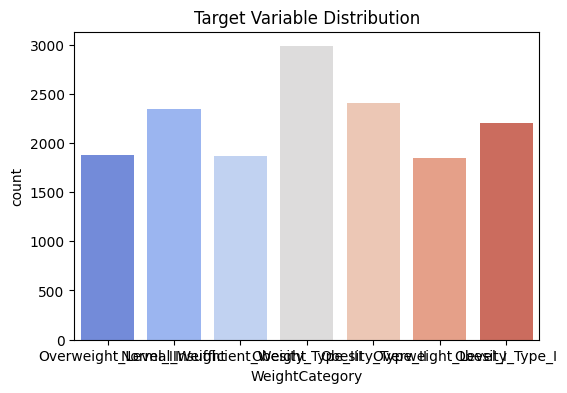

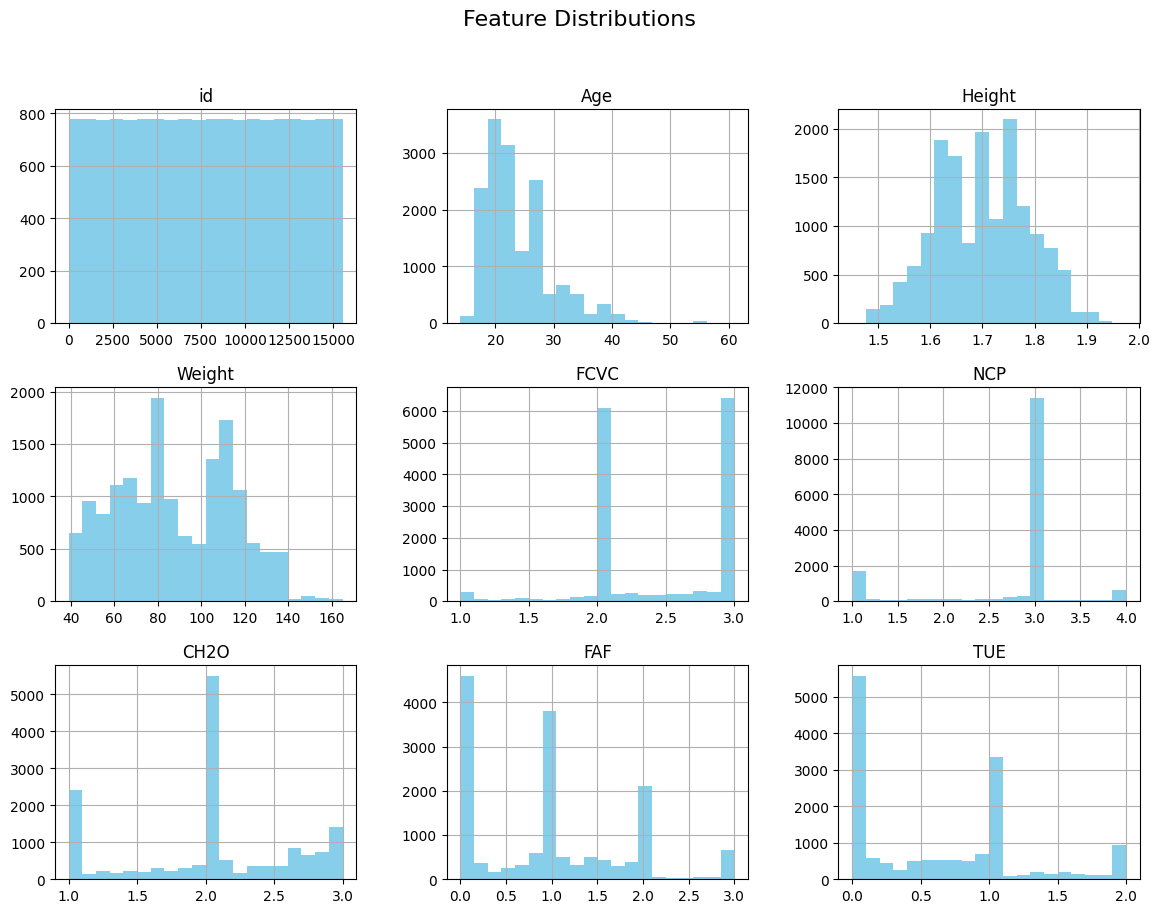

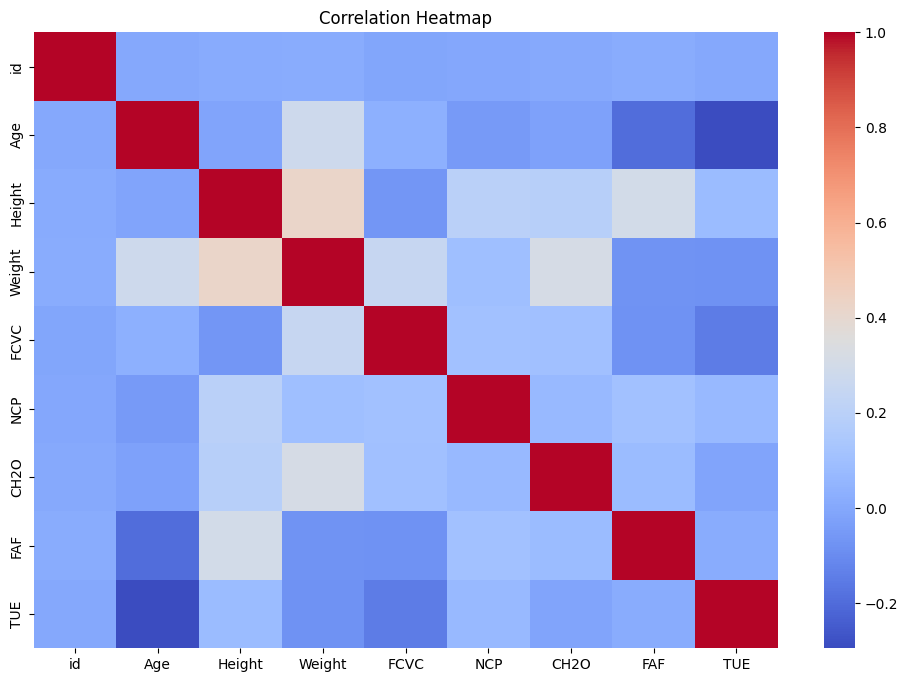

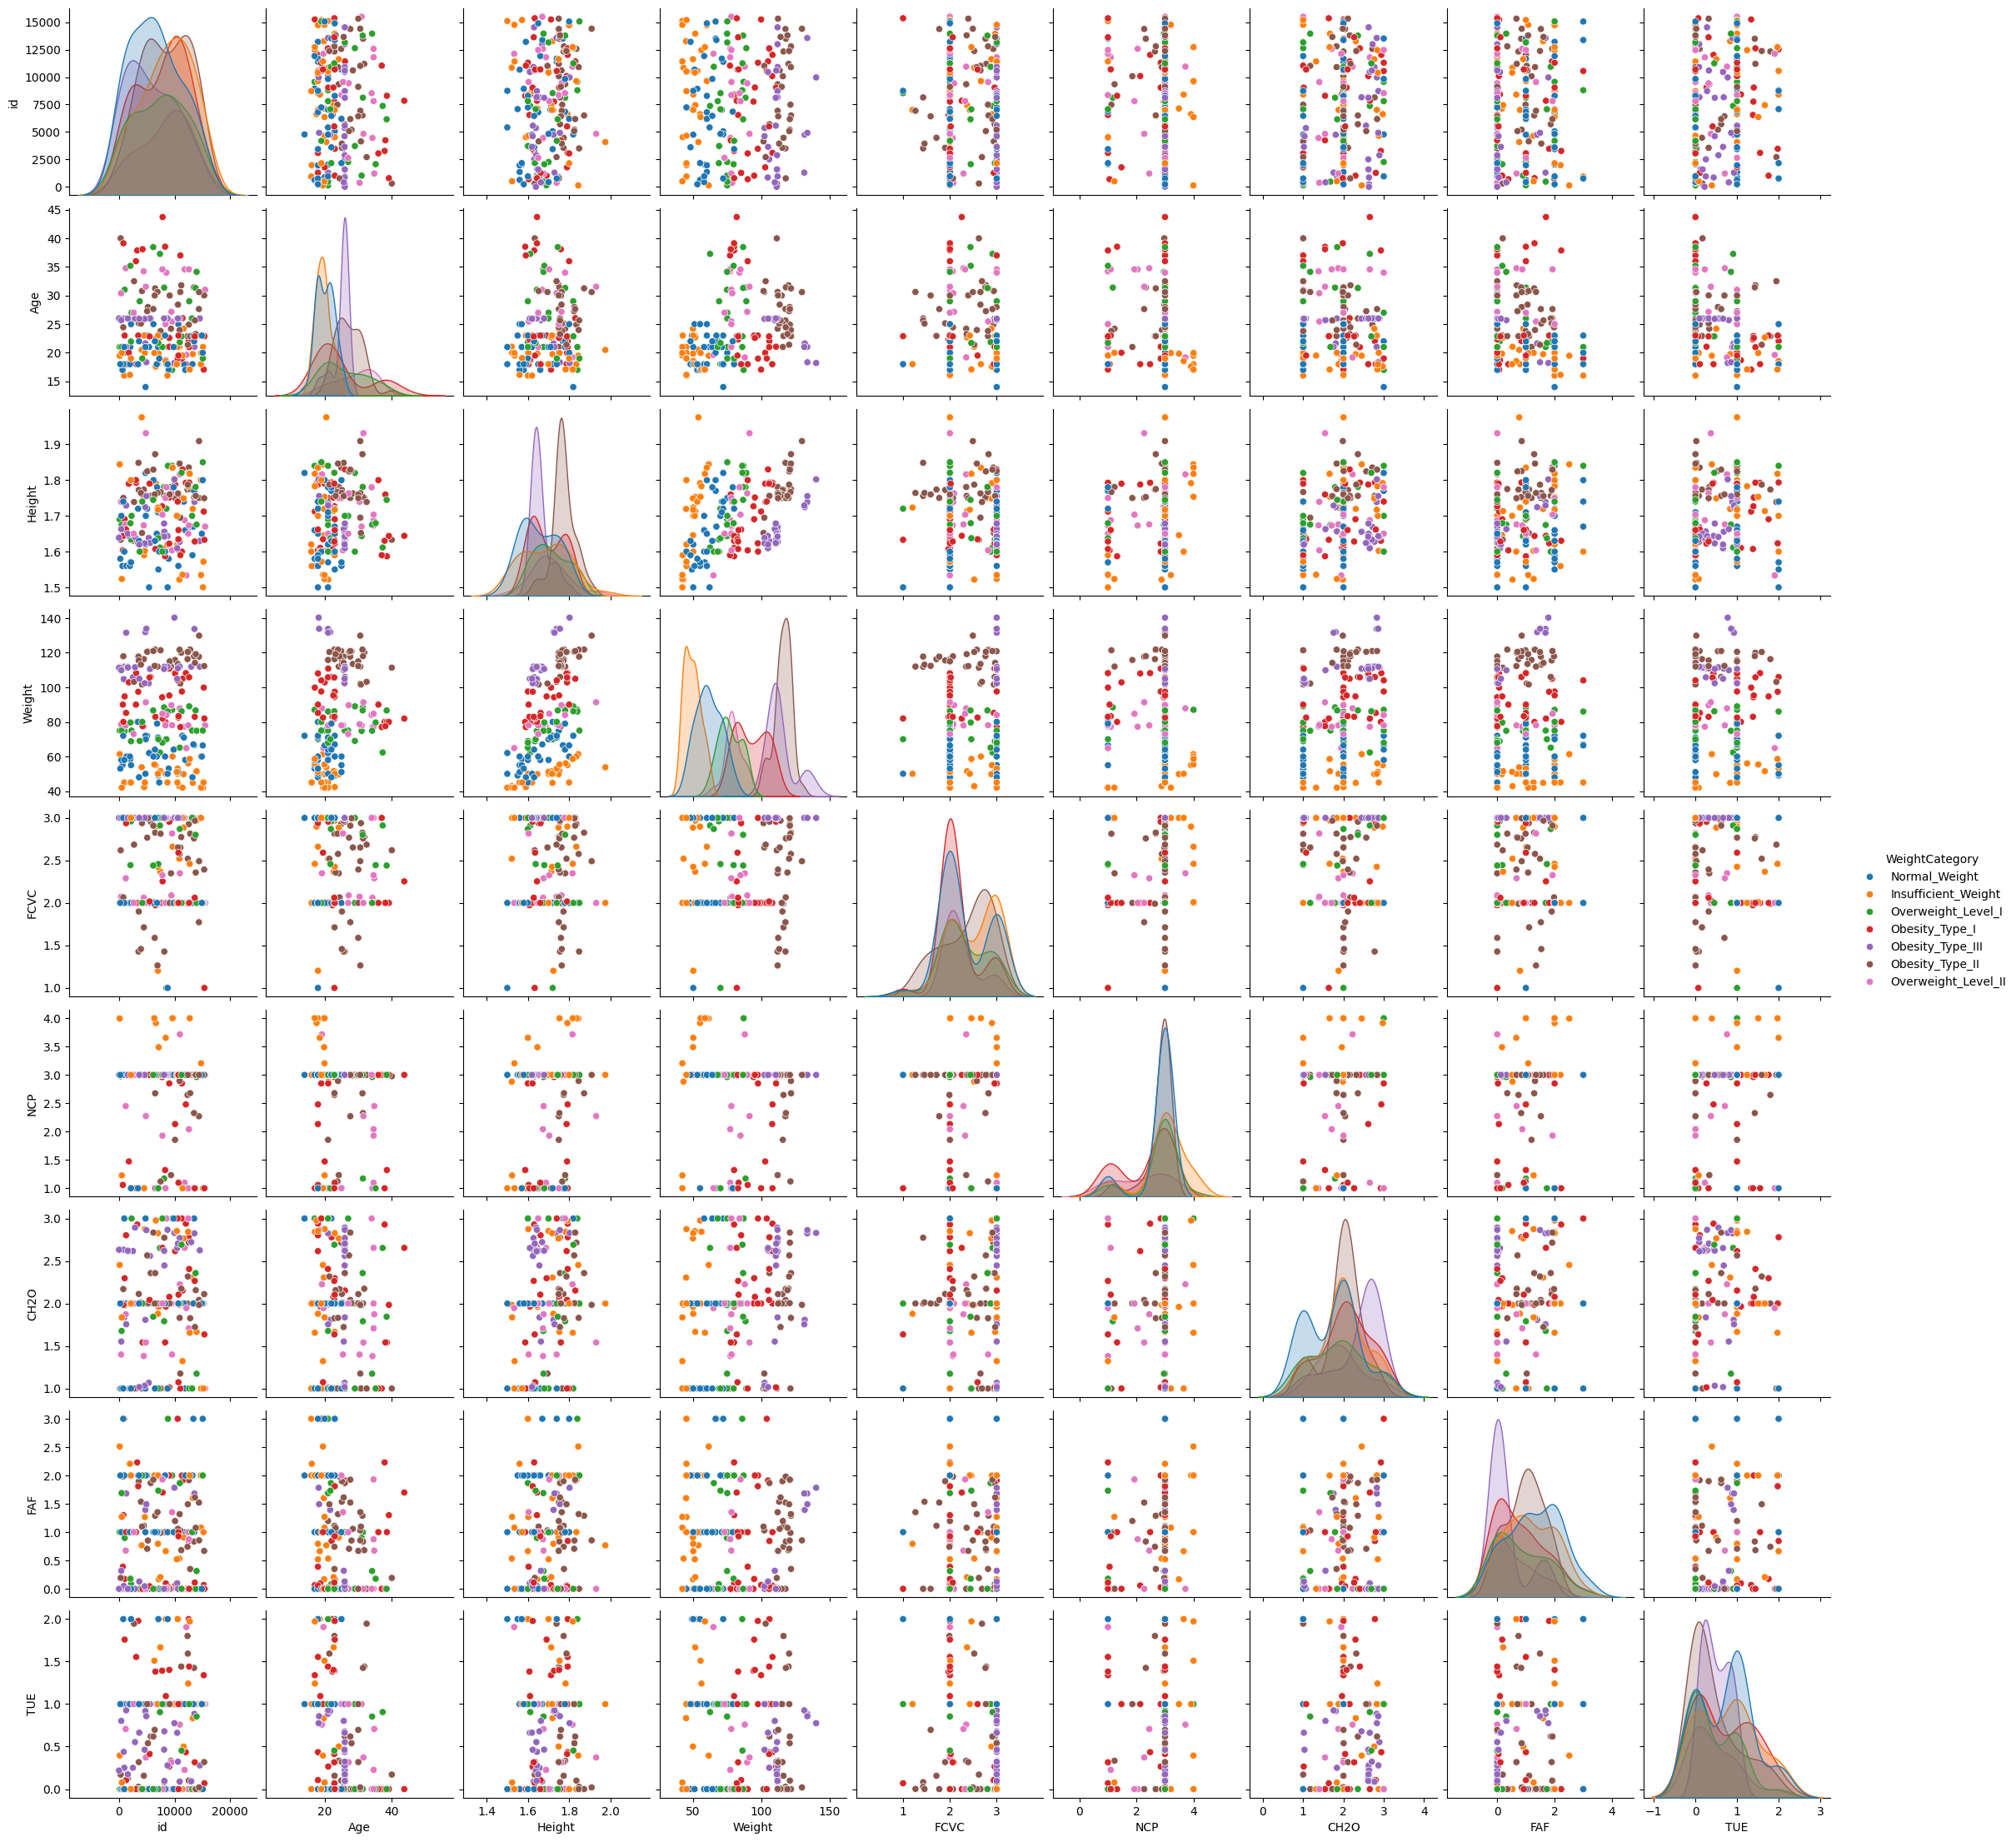


🔑 Insights:
1. Check if any features have strong correlation (>0.7) — potential redundancy.
2. Visualize target imbalance — if one class dominates, consider class weights or resampling.
3. Age, Height, Weight likely most predictive features.


In [ ]:
# ========================================
# 🔍 Step 4: Exploratory Data Analysis (EDA)
# ========================================

# ----- Basic info -----
print("\n--- Dataset Info ---")
print(train_df.info())

print("\n--- Missing Values ---")
print(train_df.isnull().sum())

print("\n--- Descriptive Statistics ---")
print(train_df.describe())

# ----- Distribution of target -----
plt.figure(figsize=(6,4))
sns.countplot(x='WeightCategory', data=train_df, palette='coolwarm')
plt.title("Target Variable Distribution")
plt.show()

# ----- Numerical feature distributions -----
num_cols = train_df.select_dtypes(include=['int64','float64']).columns
train_df[num_cols].hist(bins=20, figsize=(14,10), color='skyblue')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# ----- Correlation heatmap -----
plt.figure(figsize=(12,8))
# FIX: Added numeric_only=True to ignore string columns
sns.heatmap(train_df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# ----- Pairplot (optional for quick relationships) -----
sns.pairplot(train_df.sample(min(200, len(train_df))), hue='WeightCategory', diag_kind='kde')
plt.show()

# ----- Key insights (printed) -----
print("\n🔑 Insights:")
print("1. Check if any features have strong correlation (>0.7) — potential redundancy.")
print("2. Visualize target imbalance — if one class dominates, consider class weights or resampling.")
print("3. Age, Height, Weight likely most predictive features.")

In [ ]:
print("✅ Train Data Preview:")
print(train_df.head(3))
print("\n✅ Test Data Preview:")
print(test_df.head(3))

✅ Train Data Preview:
   id  Gender        Age    Height     Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998  81.669950                            yes   
1   1  Female  18.000000  1.560000  57.000000                            yes   
2   2  Female  18.000000  1.711460  50.165754                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   

        TUE       CALC                 MTRANS       WeightCategory  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  

✅ Test Data Preview:
      id  Gender        Age    Height      Weight  \
0  15533  Female 

In [ ]:
# Step 4: Encode categorical columns
label_encoders = {}
for col in train_df.select_dtypes(include=['object']).columns:
    if col == 'WeightCategory':
        continue  # don't encode target here
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le


In [ ]:
# Step 5: Encode target column separately
target_encoder = LabelEncoder()
train_df['WeightCategory'] = target_encoder.fit_transform(train_df['WeightCategory'])


In [ ]:
# Step 6: Split data
X = train_df.drop(columns=['WeightCategory'])
y = train_df['WeightCategory']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Step 7: Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

# Step 8: Evaluate
val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print(f"\n✅ Validation Accuracy: {val_acc * 100:.2f}%")


✅ Validation Accuracy: 89.80%


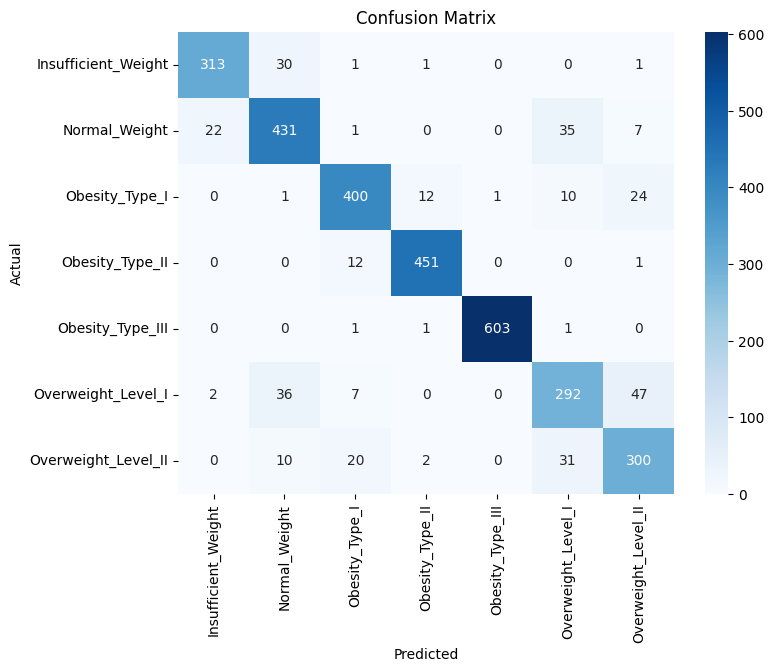

In [ ]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Step 9: Predict on test.csv
test_pred = model.predict(test_df)

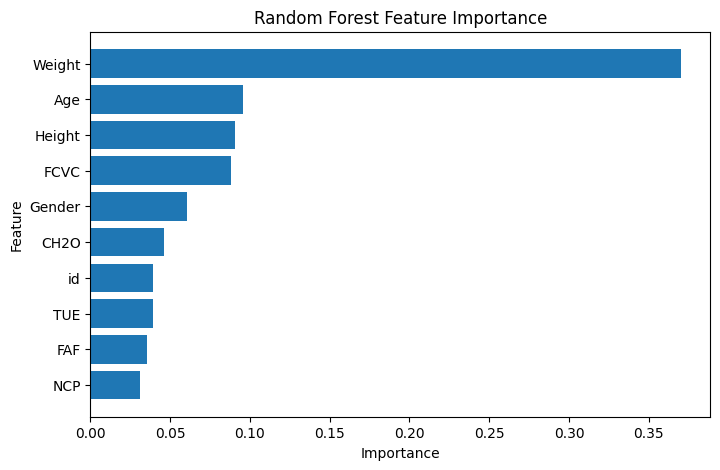

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rf_model is your trained RandomForestClassifier
importances = model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
# Step 10: Decode predictions back to original labels
test_pred_labels = target_encoder.inverse_transform(test_pred)


In [ ]:
# Step 11: Save predictions
output = pd.DataFrame({
    'id': test_df['id'],
    'Predicted_WeightCategory': test_pred_labels
})
output.to_csv('predictions.csv', index=False)

print("\n🎉 Predictions saved to predictions.csv")



🎉 Predictions saved to predictions.csv


In [ ]:
# Step 12: Download file
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>